# Employee Attrition Analysis
This notebook explores the factors contributing to employee attrition using the IBM HR Analytics Employee Attrition dataset.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from scipy.stats import ttest_ind
import os
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import numpy as np
from sklearn.model_selection import learning_curve
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import RFE
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve
from sklearn.calibration import CalibratedClassifierCV
import joblib
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from imblearn.combine import SMOTEENN
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
import shap
from fastapi import FastAPI
from pydantic import BaseModel
from typing import List
from IPython.display import display
from xgboost import XGBClassifier

In [3]:
# Load the dataset
df = pd.read_csv('../data/raw/WA_Fn-UseC_-HR-Employee-Attrition.csv')

# Output success message
print("Dataset loaded successfully!")

Dataset loaded successfully!


## Exploratory Data Analysis (EDA)

### Data Overview 

In [4]:
# Display first few rows 
df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


In [5]:
# Dataset info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   int64 
 14  JobLevel                

General Dataset Structure:
- Each row represents a single employee.
- Each column represents a feature (attribute) about the employee, such as age, job role, and whether they left the company (Attrition).
  
Data Types and Formatting
- "Yes" and "No" in the Attrition column suggest it's currently stored as string (object) data instead of numerical (1 for Yes, 0 for No). We may need to rethink that.
- Other categorical columns like BusinessTravel, Department, EducationField, MaritalStatus, OverTime are also text-based, meaning they will need encoding before they can be used in the model.
- Numerical values such as Age, DailyRate, DistanceFromHome, TotalWorkingYears appear as expected.

Potentially Redundant Columns
- EmployeeCount: If it’s always 1, it doesn’t provide useful information.
- StandardHours: If it’s always 80, it’s redundant.
- Over18: Likely always "Yes" (since all employees are over 18), so it’s unnecessary.

### Summary Statistics

In [6]:
# Summary for numerical features
df.describe()

,Age,DailyRate,DistanceFromHome,Education,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
count,1470.000000,1470.000000,1470.000000,1470.000000,1470.0,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,...,1470.000000,1470.0,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000
mean,36.923810,802.485714,9.192517,2.912925,1.0,1024.865306,2.721769,65.891156,2.729932,2.063946,...,2.712245,80.0,0.793878,11.279592,2.799320,2.761224,7.008163,4.229252,2.187755,4.123129
std,9.135373,403.509100,8.106864,1.024165,0.0,602.024335,1.093082,20.329428,0.711561,1.106940,...,1.081209,0.0,0.852077,7.780782,1.289271,0.706476,6.126525,3.623137,3.222430,3.568136
min,18.000000,102.000000,1.000000,1.000000,1.0,1.000000,1.000000,30.000000,1.000000,1.000000,...,1.000000,80.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,30.000000,465.000000,2.000000,2.000000,1.0,491.250000,2.000000,48.000000,2.000000,1.000000,...,2.000000,80.0,0.000000,6.000000,2.000000,2.000000,3.000000,2.000000,0.000000,2.000000
50%,36.000000,802.000000,7.000000,3.000000,1.0,1020.500000,3.000000,66.000000,3.000000,2.000000,...,3.000000,80.0,1.000000,10.000000,3.000000,3.000000,5.000000,3.000000,1.000000,3.000000
75%,43.000000,1157.000000,14.000000,4.000000,1.0,1555.750000,4.000000,83.750000,3.000000,3.000000,...,4.000000,80.0,1.000000,15.000000,3.000000,3.000000,9.000000,7.000000,3.000000,7.000000
max,60.000000,1499.000000,29.000000,5.000000,1.0,2068.000000,4.000000,100.000000,4.000000,5.000000,...,4.000000,80.0,3.000000,40.000000,6.000000,4.000000,40.000000,18.000000,15.000000,17.000000


Some columns are likely redundant:

- EmployeeCount: Always 1.0 so could potentially be dropped.
- StandardHours: Always 80.0, could also potentially be dropped. 

Wide range of values in some features:

- DistanceFromHome: Ranges from 1 to 29.
- TotalWorkingYears: Ranges from 0 to 40.
- YearsSinceLastPromotion: Ranges from 0 to 15.

** These could indicate potential outliers that may need capping.

Categorical-like numerical features:

- Education (1-5)
- JobLevel (1-5)
- StockOptionLevel (0-3)

** Are actually ordinal categorical variables, not continuous.

Monthly Income:

Needs to be checked against attrition to see if it's a contributing factor.


In [7]:
# Summary for categorical features
df.select_dtypes(include=['object']).nunique()

Attrition         2
BusinessTravel    3
Department        3
EducationField    6
Gender            2
JobRole           9
MaritalStatus     3
Over18            1
OverTime          2
dtype: int64

- Attrition has 2 values (Yes, No) - Needs to be converted to 0 and 1.
- Over18 has only 1 unique value - Can be dropped.
- BusinessTravel, Department, MaritalStatus - Have 3 categories each, meaning they need one-hot encoding.
- EducationField has 6 categories - Will need one-hot encoding.

### Understanding the state of the data

In [8]:
# Check for missing values
df.isnull().sum()

Age                         0
Attrition                   0
BusinessTravel              0
DailyRate                   0
Department                  0
DistanceFromHome            0
Education                   0
EducationField              0
EmployeeCount               0
EmployeeNumber              0
EnvironmentSatisfaction     0
Gender                      0
HourlyRate                  0
JobInvolvement              0
JobLevel                    0
JobRole                     0
JobSatisfaction             0
MaritalStatus               0
MonthlyIncome               0
MonthlyRate                 0
NumCompaniesWorked          0
Over18                      0
OverTime                    0
PercentSalaryHike           0
PerformanceRating           0
RelationshipSatisfaction    0
StandardHours               0
StockOptionLevel            0
TotalWorkingYears           0
TrainingTimesLastYear       0
WorkLifeBalance             0
YearsAtCompany              0
YearsInCurrentRole          0
YearsSince

In [9]:
# Check for duplicate rows
duplicate_count = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_count}")

if duplicate_count > 0:
    df.drop_duplicates(inplace=True)
    print("Duplicates removed.")

Number of duplicate rows: 0


No missing values in any column and no duplicate records - The dataset is complete and does not require imputation.

In [10]:
categorical_columns = [
    'BusinessTravel', 'Department', 'EducationField', 
    'Gender', 'JobRole', 'MaritalStatus', 'Over18'
]

# Standardize string columns
for col in categorical_columns:
    if col in df.columns and df[col].dtype == 'object':
        df[col] = df[col].str.strip().str.capitalize()
    else:
        print(f"Skipping column '{col}' because it is not a string.")

# Handle 'OverTime_Yes' separately
if 'OverTime_Yes' in df.columns:
    df['OverTime_Yes'] = df['OverTime_Yes'].astype(str)

# Verify the transformation
for col in categorical_columns + ['OverTime_Yes']:
    if col in df.columns:
        print(f"{col}: {df[col].unique()}")

BusinessTravel: ['Travel_rarely' 'Travel_frequently' 'Non-travel']
Department: ['Sales' 'Research & development' 'Human resources']
EducationField: ['Life sciences' 'Other' 'Medical' 'Marketing' 'Technical degree'
 'Human resources']
Gender: ['Female' 'Male']
JobRole: ['Sales executive' 'Research scientist' 'Laboratory technician'
 'Manufacturing director' 'Healthcare representative' 'Manager'
 'Sales representative' 'Research director' 'Human resources']
MaritalStatus: ['Single' 'Married' 'Divorced']
Over18: ['Y']


In [11]:
# Droping Non-Informative Columns
df.drop(columns=['Over18'], inplace=True)

### Convert Attrition to Numerical 

In [12]:
df['Attrition'] = df['Attrition'].map({'Yes': 1, 'No': 0})

# Count occurrences of each attrition category
attrition_counts = df['Attrition'].value_counts()

# Print the counts
print(f"Attrition = 1 (Yes) count: {attrition_counts.get(1, 0)}")
print(f"Attrition = 0 (No) count: {attrition_counts.get(0, 0)}")

Attrition = 1 (Yes) count: 237
Attrition = 0 (No) count: 1233


Converting Attrition from categorical ("Yes", "No") to numerical (1, 0) for analysis.

### Statistical Tests 

####  Relationship Between Attrition and Job Role (Chi-Square Test)

In [13]:
# Create a contingency table for Attrition and Job Role
contingency_table = pd.crosstab(df['Attrition'], df['JobRole'])

# Perform the Chi-Square test
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Print results with scientific notation for p-value
print(f"Chi2 Statistic: {chi2:.4f}, p-value: {p}")

# Interpretation
if p < 0.05:
    print("Result: Significant relationship between Job Role and Attrition.")
else:
    print("Result: No significant relationship between Job Role and Attrition.")


Chi2 Statistic: 86.1903, p-value: 2.752481638050657e-15
Result: Significant relationship between Job Role and Attrition.


- A low p-value (< 0.05) means that Job Role and Attrition are not independent.
- This suggests certain job roles have higher attrition rates than others.

#### Monthly Income and Attrition (Independent t-Test)

In [14]:
# Split data based on Attrition
attrition_yes = df[df['Attrition'] == 1] ['MonthlyIncome']
attrition_no = df[df['Attrition'] == 0 ]['MonthlyIncome']

# Perform t-test assuming unequal variance (Welch’s t-test)
t_stat, p_val = ttest_ind(attrition_yes, attrition_no, equal_var=False)

# Print results
print(f"T-statistic: {t_stat:.4f}, p-value: {p_val:.4e}")
# Interpretation
if p_val < 0.05:
    print("Result: Significant difference in Monthly Income between attrition groups.")
else:
    print("Result: No significant difference in Monthly Income between attrition groups.")


T-statistic: -7.4826, p-value: 4.4336e-13
Result: Significant difference in Monthly Income between attrition groups.


- A very low p-value (< 0.05) means that employees who leave have significantly different Monthly Income compared to those who stay.
- The negative t-statistic (-7.48) suggests that the attrition group (left the company) earns less on average than those who stayed.

### Directory Management

In [15]:
# Define the results directory
results_dir = "./results"
if not os.path.exists(results_dir):
    os.makedirs(results_dir)
    print(f"Directory '{results_dir}' created.")
else:
    print(f"Directory '{results_dir}' already exists.")

# Save the plot and print the path
save_path = f"{results_dir}/monthly_income_by_attrition.png"
print(f"Saving plot to: {save_path}")
plt.savefig(save_path)
plt.show()

Directory './results' created.
Saving plot to: ./results/monthly_income_by_attrition.png


<Figure size 640x480 with 0 Axes>

### Target Variable Analysis

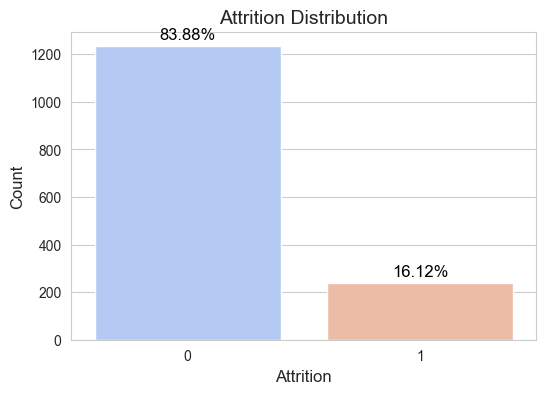

In [16]:
# Set plot style
sns.set_style("whitegrid")

# Create figure
plt.figure(figsize=(6, 4))
ax = sns.countplot(x='Attrition', hue='Attrition', data=df, palette="coolwarm", legend=False)

# Add percentages above bars
total = len(df)
for p in ax.patches:
    percentage = f"{100 * p.get_height() / total:.2f}%"
    ax.annotate(percentage, 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='baseline', fontsize=12, color='black', xytext=(0, 5),
                textcoords='offset points')

# Labels and Title
plt.title('Attrition Distribution', fontsize=14)
plt.xlabel('Attrition', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()

In [17]:
# Print attrition percentages
attrition_rate = df['Attrition'].value_counts(normalize=True) * 100
print("Attrition Rate (%):")
print(attrition_rate.round(2))

Attrition Rate (%):
Attrition
0    83.88
1    16.12
Name: proportion, dtype: float64


### Bivariate Analysis

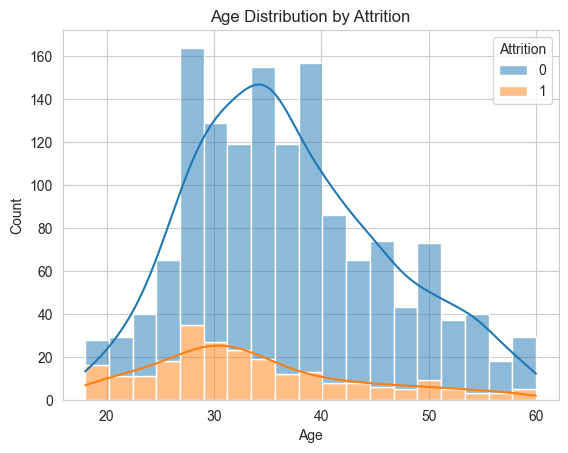

Attrition,0,1
Age,,
18,4,4
19,3,6
20,5,6
21,7,6
22,11,5
23,10,4
24,19,7
25,20,6
26,27,12


In [18]:
# Plot Age Distribution by Attrition
sns.histplot(data=df, x='Age', hue='Attrition', multiple='stack', kde=True)
plt.title('Age Distribution by Attrition')
plt.show()
# Create a contingency table for Age and Attrition
age_table = df.groupby(['Age', 'Attrition']).size().unstack(fill_value=0)

# Display the table
display(age_table)

**Younger employees (18-25) have higher attrition rates**
- For example, ages 18-25 have a higher number of employees leaving compared to older age groups.
- At age 18, the ratio of attrition is 4 (stayed) vs. 4 (left) - 50% attrition.
- At age 19, it's 3 (stayed) vs. 6 (left) - 66.7% attrition.

Attrition stabilizes in mid-career (30-40)
- More employees stay in the company at these ages.
- Example: Age 34, 68 stayed vs. 9 left - 11.69% attrition 
  
Older employees (50+) rarely leave
- Attrition at ages 54-60 is nearly zero.
- Suggests older employees are more likely to stay due to job security, nearing retirement, or tenure benefits.

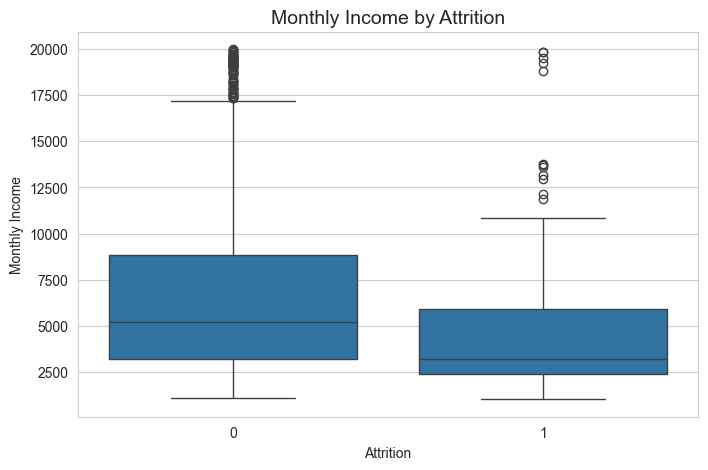

,count,mean,std,min,25%,50%,75%,max
Attrition,,,,,,,,
0,1233.0,6832.739659,4818.208001,1051.0,3211.0,5204.0,8834.0,19999.0
1,237.0,4787.092827,3640.210367,1009.0,2373.0,3202.0,5916.0,19859.0


In [19]:
# Plot Monthly Income by Attrition
plt.figure(figsize=(8,5))
sns.boxplot(x='Attrition', y='MonthlyIncome', data=df)
plt.title('Monthly Income by Attrition', fontsize=14)
plt.xlabel('Attrition')
plt.ylabel('Monthly Income')
plt.show()

# Create a summary table of Monthly Income statistics by Attrition
income_table = df.groupby('Attrition')['MonthlyIncome'].describe()

# Display the table
display(income_table)

**Employees who stayed (Attrition = 0) tend to have higher incomes**

- Mean Monthly Income: \$6,832.74
- Median (50th percentile): \$5,204
- 75th percentile: \$8,834
- Maximum: \$19,999

**Employees who left (Attrition = 1) tend to have lower incomes**

- Mean Monthly Income: \$4,787.09
- Median (50th percentile): \$3,202
- 75th percentile: \$5,916
- Maximum: \$19,859 (similar to those who stayed)
  
Standard Deviation:
- Employees who stayed have a wider spread in their monthly income.
- This suggests that those who stayed include both very high and very low earners, whereas those who left are more concentrated in the lower income range.

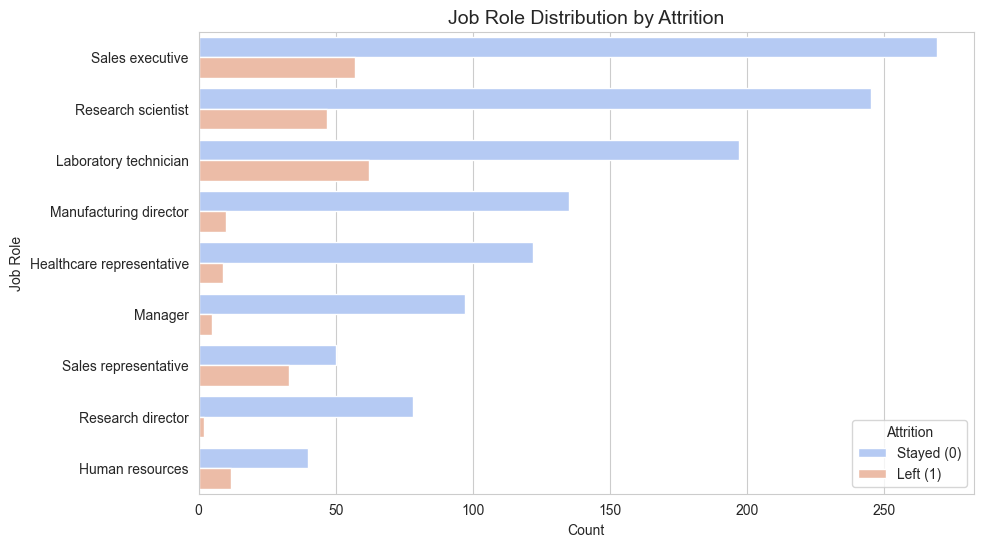

Attrition,0,1
JobRole,,
Healthcare representative,122,9
Human resources,40,12
Laboratory technician,197,62
Manager,97,5
Manufacturing director,135,10
Research director,78,2
Research scientist,245,47
Sales executive,269,57
Sales representative,50,33


In [20]:
# Plot Job Role Distribution by Attrition
plt.figure(figsize=(10,6))
sns.countplot(y='JobRole', hue='Attrition', data=df, order=df['JobRole'].value_counts().index, palette="coolwarm")
plt.title('Job Role Distribution by Attrition', fontsize=14)
plt.xlabel('Count')
plt.ylabel('Job Role')
plt.legend(title="Attrition", labels=["Stayed (0)", "Left (1)"])
plt.show()

# Create a contingency table for Job Role and Attrition
jobrole_table = df.groupby('JobRole')['Attrition'].value_counts().unstack(fill_value=0)

# Display the table
display(jobrole_table)

**Sales Representatives Have the Highest Attrition Rate**
- 33 out of 83 (Sales Rep attrition rate 39.8%).
- This is significantly higher than any other job role.
- Indicates high turnover in Sales Representative positions.

**Laboratory Technicians, Human Resources and Sales Executives Also Have Higher Attrition**

- 62 out of 259 Laboratory Technicians left (23.9% attrition rate).
- 12 out of 52 left (23.1% attrition rate).
- 57 out of 326 Sales Executives left (17.5% attrition rate).

**Managers, Research Directors, and Healthcare Representatives Have the Lowest Attrition**
- Managers: Only 5 out of 102 left (4.9% attrition rate).
- Research Directors: Only 2 out of 80 left (2.5% attrition rate).
- Healthcare Representatives: 9 out of 131 left (6.9% attrition rate).

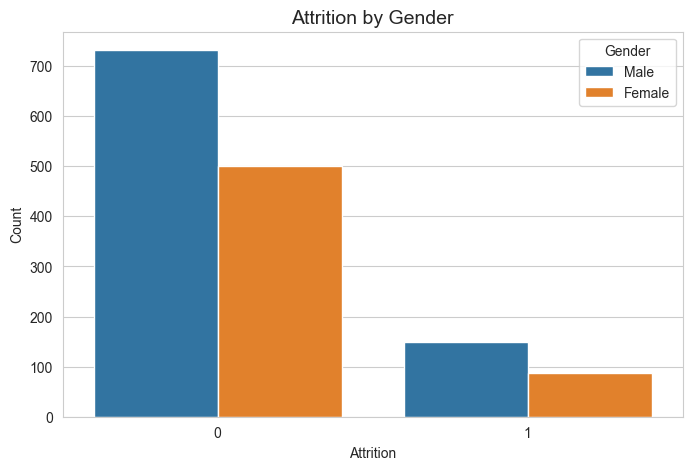

Attrition,0,1
Gender,,
Female,501,87
Male,732,150


In [21]:
# Attrition by Gender
plt.figure(figsize=(8,5))
sns.countplot(x='Attrition', hue='Gender', data=df)
plt.title('Attrition by Gender', fontsize=14)
plt.xlabel('Attrition')
plt.ylabel('Count')
plt.legend(title='Gender')
plt.show()

# Create a contingency table for Attrition by Gender
gender_attrition_table = df.groupby(['Gender', 'Attrition']).size().unstack(fill_value=0)
display(gender_attrition_table) 

Female Attrition Rate = 87 / 588 × 100 = 14.8%

Male Attrition Rate = 105 / 882 x 100 = 17.0%

**Males have a slightly higher attrition rate than females (17.0% vs. 14.8%).**

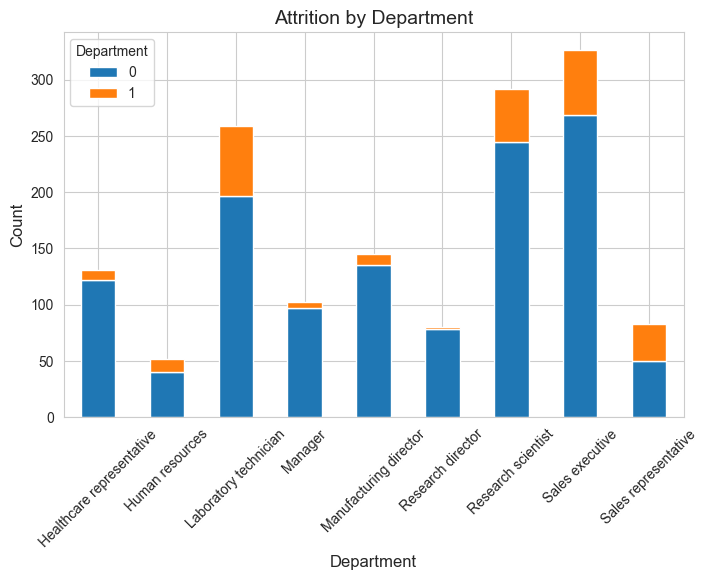

Department  Human resources  Research & development  Sales
Attrition                                                 
0                        51                     828    354
1                        12                     133     92


In [22]:
# Attrition by Department
contingency_table.T.plot(kind='bar', stacked=True, figsize=(8,5))
plt.title('Attrition by Department', fontsize=14)
plt.xlabel('Department', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45)  # Rotate for better readability
plt.legend(title='Department')  # Now correctly shows departments
plt.show()

contingency_table = pd.crosstab(df['Attrition'], df['Department'])
print(contingency_table)

HR Attrition Rate = 12 / 63 × 100 = 19.0%

R&D Attrition Rate = 133 / 961 x 100 = 13.8%

Sales Attrition Rate = 92 / 446 x 100 = 20.6%

**Sales has the highest attrition rate (20.6%), followed by HR (19.0%), while R&D has the lowest attrition rate (13.8%).**

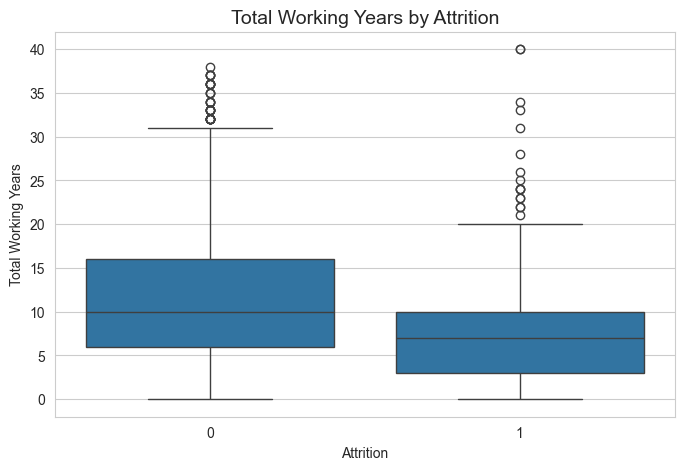

Attrition,0,1
TotalWorkingYears,,
0,6,5
1,41,40
2,22,9
3,33,9
4,51,12
5,72,16
6,103,22
7,63,18
8,87,16


In [23]:
# Total Working Years by Attrition (Boxplot)
plt.figure(figsize=(8,5))
sns.boxplot(x='Attrition', y='TotalWorkingYears', data=df)
plt.title('Total Working Years by Attrition', fontsize=14)
plt.xlabel('Attrition')
plt.ylabel('Total Working Years')
plt.show()

# Create a contingency table for Total Working Years by Attrition
total_working_years_table = df.groupby(['TotalWorkingYears', 'Attrition']).size().unstack(fill_value=0)

# Display the table
display(total_working_years_table) 

**Newer employees (0-5 years) are at the highest risk of leaving.**

Attrition rates stabilize after 6+ years.

Employees with 20+ years rarely leave, possibly due to pension plans, loyalty, or nearing retirement.

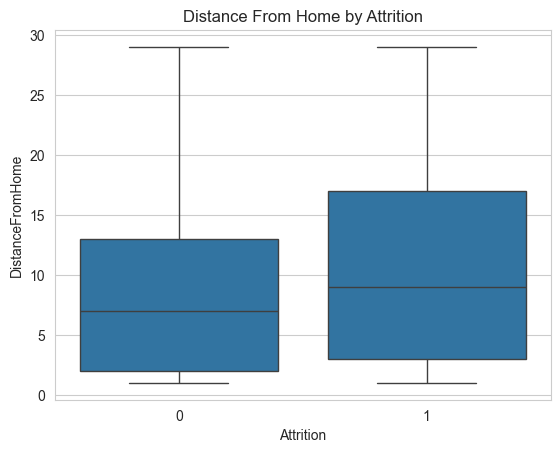

Attrition,0,1
DistanceFromHome,,
1,182,26
2,183,28
3,70,14
4,55,9
5,55,10
6,52,7
7,73,11
8,70,10
9,67,18


In [24]:
# DistanceFromHome vs Attrition
sns.boxplot(x='Attrition', y='DistanceFromHome', data=df)
plt.title('Distance From Home by Attrition')
plt.show()

# Create a contingency table
Distancefromhome_table = df.groupby(['DistanceFromHome', 'Attrition']).size().unstack(fill_value=0)

# Display the table
display(Distancefromhome_table) 

- Employees with a short commute (1–3 miles) tend to stay.
- Employees with a long commute (20+ miles) have a higher likelihood of leaving.
- Distance alone does not fully explain attrition, and other factors (job satisfaction, pay, work-life balance) must be considered.

### Correlation Analysis

In [25]:
df_encoded = pd.get_dummies(df, drop_first=True)

# Select only numeric columns
numeric_df = df.select_dtypes(include=['number'])

# Compute correlation matrix
corr_matrix = numeric_df.corr()

# Display correlation matrix as a table
display(corr_matrix) 

,Age,Attrition,DailyRate,DistanceFromHome,Education,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
Age,1.000000,-0.159205,0.010661,-0.001686,0.208034,NaN,-0.010145,0.010146,0.024287,0.029820,...,0.053535,NaN,0.037510,0.680381,-0.019621,-0.021490,0.311309,0.212901,0.216513,0.202089
Attrition,-0.159205,1.000000,-0.056652,0.077924,-0.031373,NaN,-0.010577,-0.103369,-0.006846,-0.130016,...,-0.045872,NaN,-0.137145,-0.171063,-0.059478,-0.063939,-0.134392,-0.160545,-0.033019,-0.156199
DailyRate,0.010661,-0.056652,1.000000,-0.004985,-0.016806,NaN,-0.050990,0.018355,0.023381,0.046135,...,0.007846,NaN,0.042143,0.014515,0.002453,-0.037848,-0.034055,0.009932,-0.033229,-0.026363
DistanceFromHome,-0.001686,0.077924,-0.004985,1.000000,0.021042,NaN,0.032916,-0.016075,0.031131,0.008783,...,0.006557,NaN,0.044872,0.004628,-0.036942,-0.026556,0.009508,0.018845,0.010029,0.014406
Education,0.208034,-0.031373,-0.016806,0.021042,1.000000,NaN,0.042070,-0.027128,0.016775,0.042438,...,-0.009118,NaN,0.018422,0.148280,-0.025100,0.009819,0.069114,0.060236,0.054254,0.069065
EmployeeCount,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
EmployeeNumber,-0.010145,-0.010577,-0.050990,0.032916,0.042070,NaN,1.000000,0.017621,0.035179,-0.006888,...,-0.069861,NaN,0.062227,-0.014365,0.023603,0.010309,-0.011240,-0.008416,-0.009019,-0.009197
EnvironmentSatisfaction,0.010146,-0.103369,0.018355,-0.016075,-0.027128,NaN,0.017621,1.000000,-0.049857,-0.008278,...,0.007665,NaN,0.003432,-0.002693,-0.019359,0.027627,0.001458,0.018007,0.016194,-0.004999
HourlyRate,0.024287,-0.006846,0.023381,0.031131,0.016775,NaN,0.035179,-0.049857,1.000000,0.042861,...,0.001330,NaN,0.050263,-0.002334,-0.008548,-0.004607,-0.019582,-0.024106,-0.026716,-0.020123
JobInvolvement,0.029820,-0.130016,0.046135,0.008783,0.042438,NaN,-0.006888,-0.008278,0.042861,1.000000,...,0.034297,NaN,0.021523,-0.005533,-0.015338,-0.014617,-0.021355,0.008717,-0.024184,0.025976


**Employees with higher salaries, more experience, and senior positions are less likely to leave.**
- Attrition is negatively correlated with Total Working Years (-0.17), Monthly Income (-0.16), and Job Level (-0.17)

There are strong correlations between Job Level, Monthly Income, and Total Working Years.
- Job Level - Monthly Income (0.77)
- Job Level - Total Working Years (0.78)
- Total Working Years - Monthly Income (0.77)

This makes sense because employees with more years of experience tend to be at a higher job level and earn more.

**Attrition has a weak correlation with Distance From Home (0.08)**
- This suggests distance from home is not a strong factor in employees leaving.

### Saving Ouputs 

In [26]:
df.describe().to_csv('./results/summary_statistics.csv')

### Monthly Income and Outlier Analysis

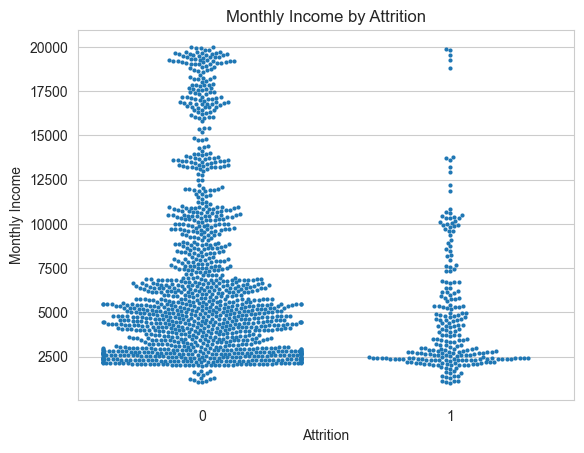

In [27]:
# Monthly income by Attrition
sns.swarmplot(x='Attrition', y='MonthlyIncome', data=df, size=3)
plt.title('Monthly Income by Attrition')
plt.ylabel('Monthly Income')
plt.xlabel('Attrition')
plt.show()

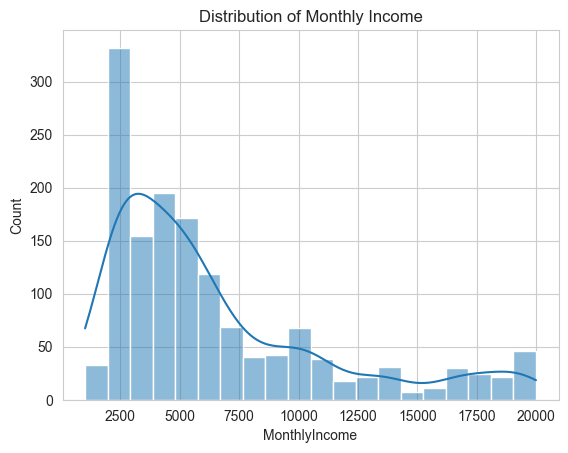

In [28]:
# Distribution of Monthly Income
sns.histplot(df['MonthlyIncome'], kde=True)
plt.title('Distribution of Monthly Income')
plt.show()

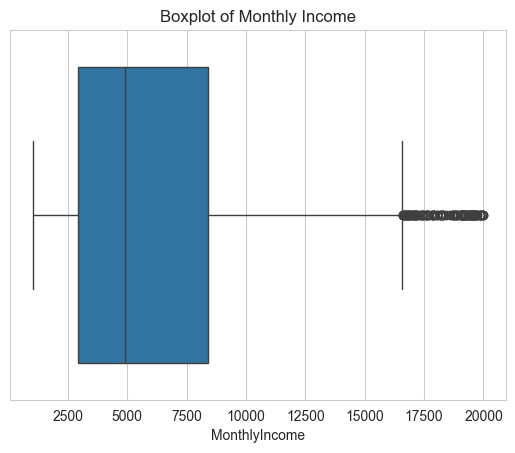

In [29]:
# Detecting outliers in Monthly Income
sns.boxplot(x=df['MonthlyIncome'])
plt.title('Boxplot of Monthly Income')
plt.show()

- **High-end outliers exist in both groups, but are more concentrated among employees who stayed.**
-  Employees who stayed generally earn more, suggesting that higher salaries may contribute to retention.
- Attrition is higher among lower-income employees, possibly due to better job opportunities elsewhere.
- Employees with very low salaries (below \$2,000) are more likely to leave, reinforcing the idea that income level is a factor in attrition.

### Gender and Job Role Insights

    Gender                    JobRole  total_employees  total_attrition  \
0   Female  Healthcare representative               51                5   
1   Female            Human resources               16                6   
2   Female      Laboratory technician               85               16   
3   Female                    Manager               47                2   
4   Female     Manufacturing director               72                4   
5   Female          Research director               33                1   
6   Female         Research scientist              114               17   
7   Female            Sales executive              132               20   
8   Female       Sales representative               38               16   
9     Male  Healthcare representative               80                4   
10    Male            Human resources               36                6   
11    Male      Laboratory technician              174               46   
12    Male               

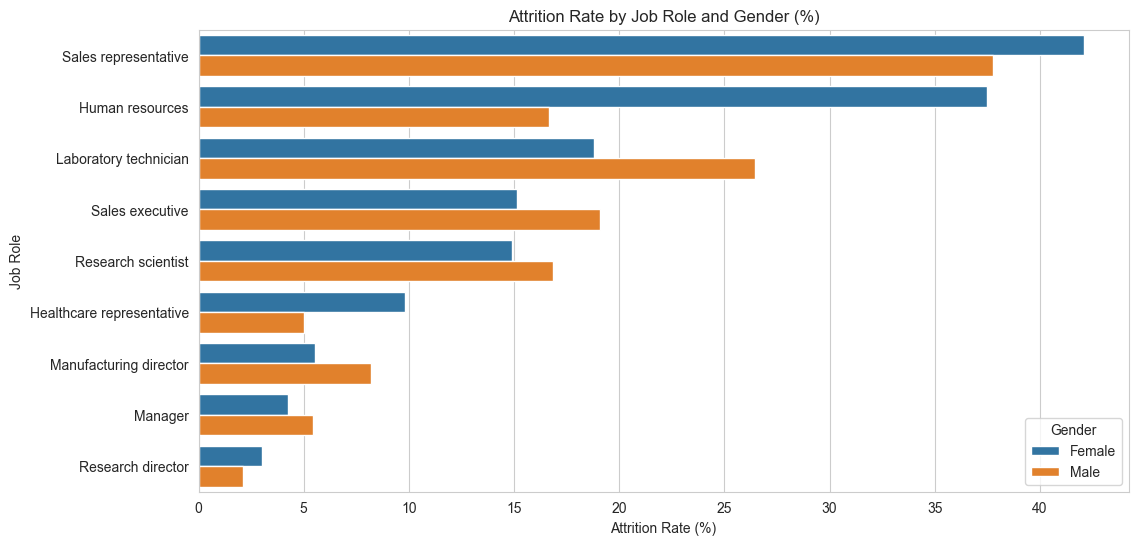

In [30]:
# Group by Gender and JobRole and calculate totals
gender_job_attrition = df.groupby(['Gender', 'JobRole']).agg(
    total_employees=('Attrition', 'count'),
    total_attrition=('Attrition', 'sum')
).reset_index()

# Calculate attrition rate
gender_job_attrition['attrition_rate'] = (
    gender_job_attrition['total_attrition'] / gender_job_attrition['total_employees']
) * 100

# Display the results
print(gender_job_attrition)

# Plot the attrition rate by Job Role and Gender
plt.figure(figsize=(12, 6))
sns.barplot(
    x='attrition_rate', 
    y='JobRole', 
    hue='Gender', 
    data=gender_job_attrition.sort_values('attrition_rate', ascending=False)
)
plt.title('Attrition Rate by Job Role and Gender (%)')
plt.xlabel('Attrition Rate (%)')
plt.ylabel('Job Role')
plt.legend(title='Gender')
plt.show()

**Sales and HR roles experience the highest attrition, especially among females.**
- Companies may need to investigate workplace conditions, compensation, and job expectations in these roles.

**Technical roles like Laboratory Technician have high attrition, especially for men.**
- Companies may need to explore career growth opportunities to retain these employees.

**Managerial roles and senior technical roles (e.g., Research Director) have the lowest attrition.**
- Likely due to job stability, higher pay, and career progression opportunities.

### Outlier Detection

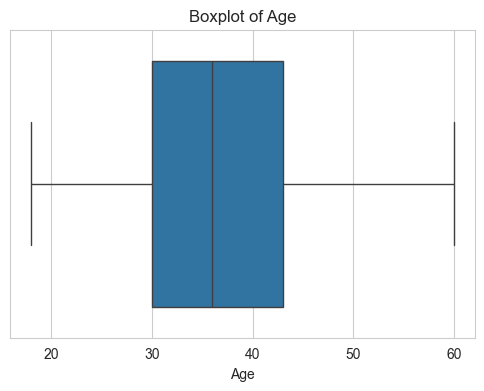

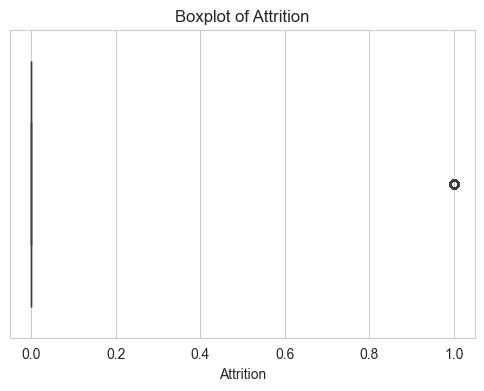

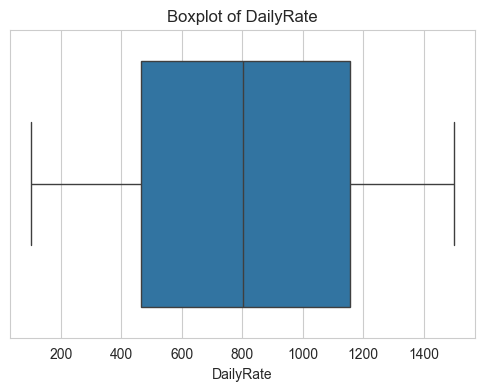

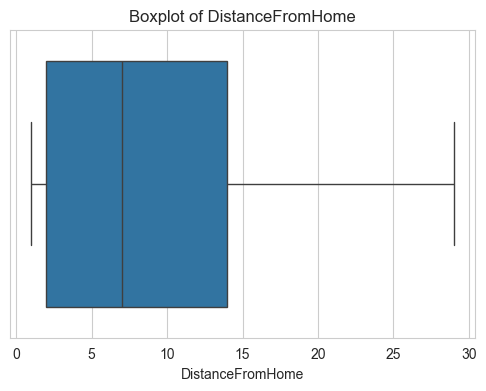

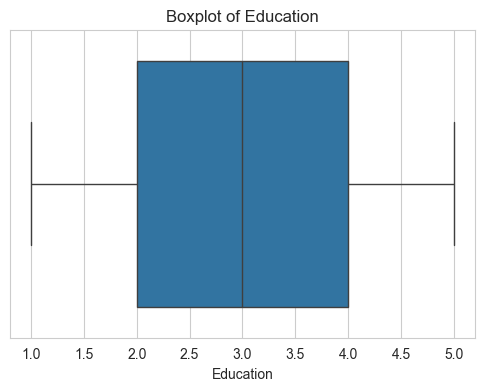

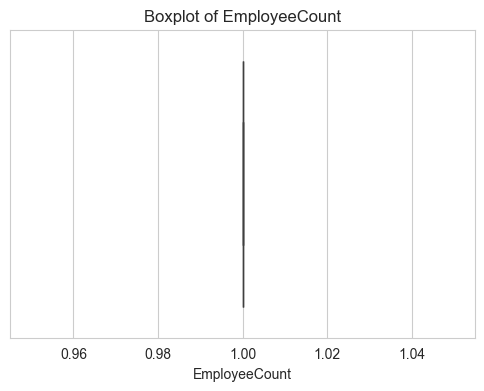

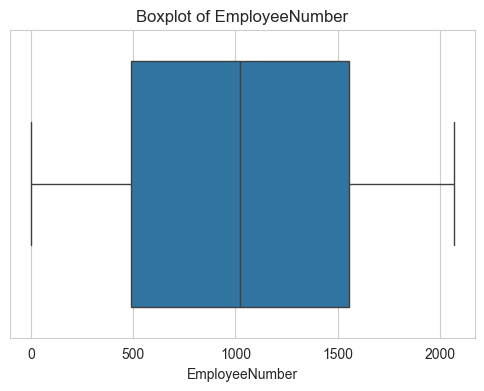

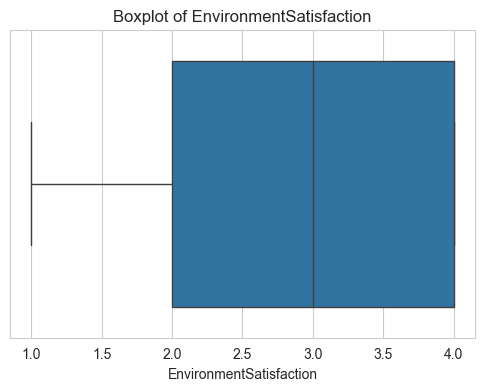

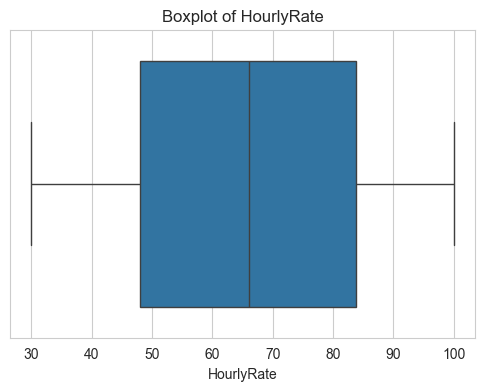

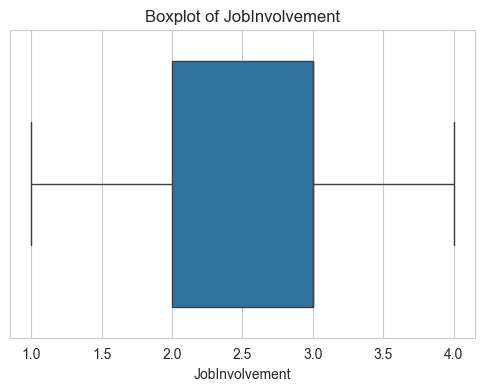

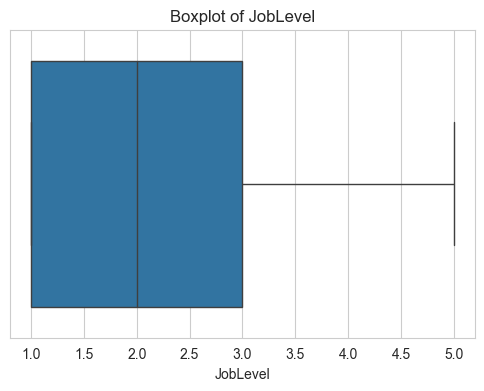

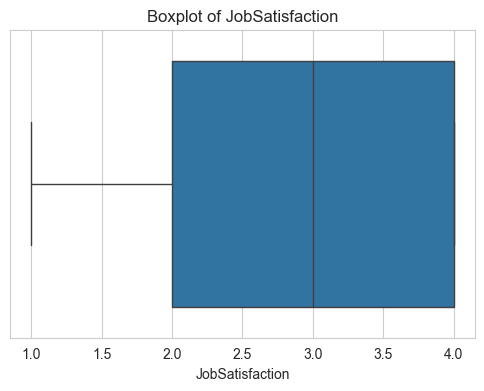

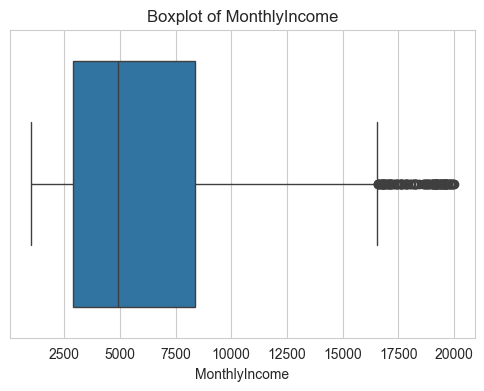

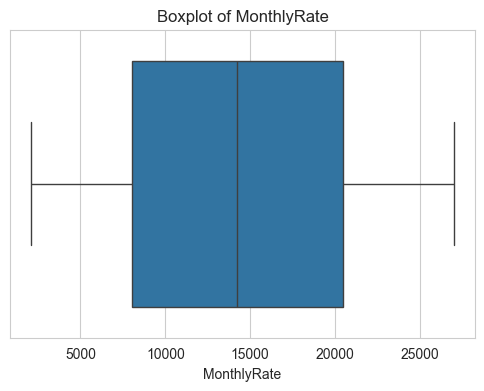

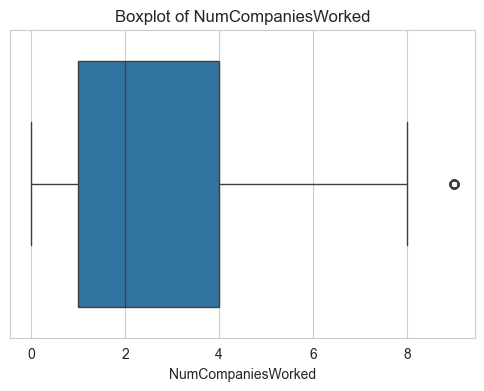

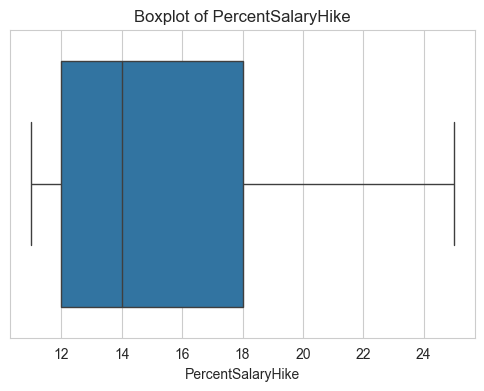

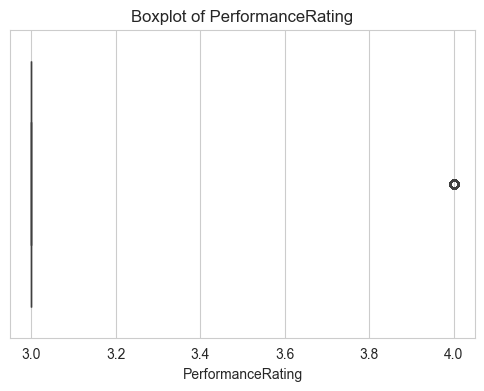

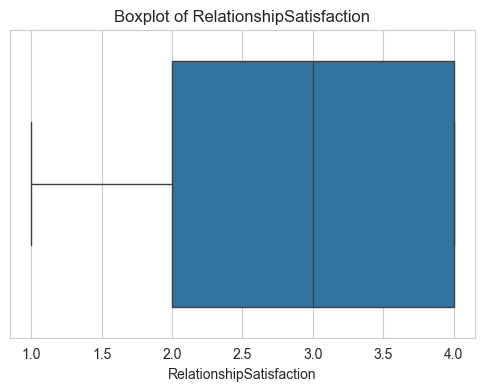

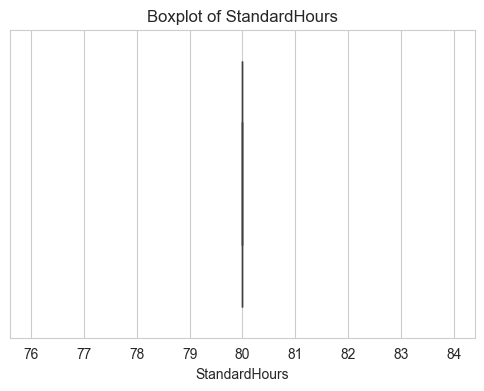

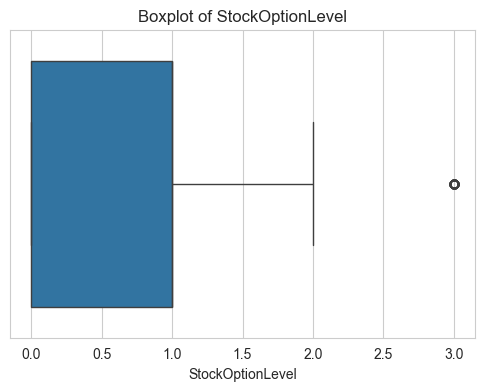

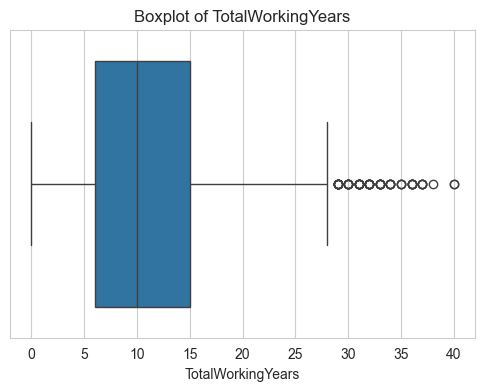

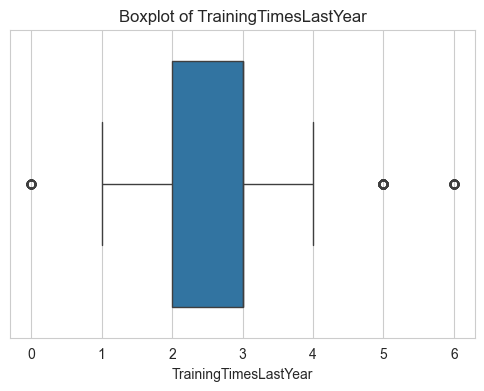

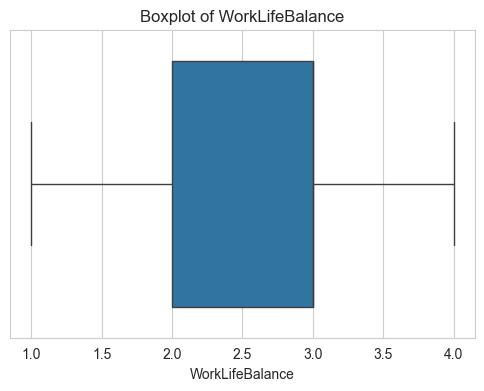

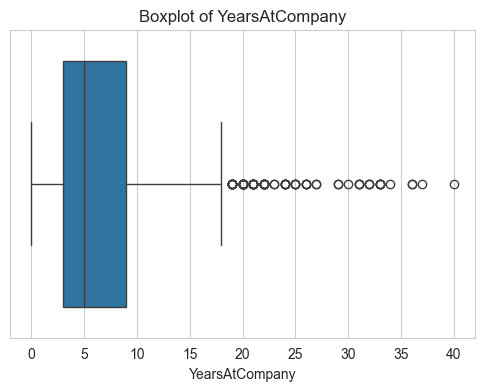

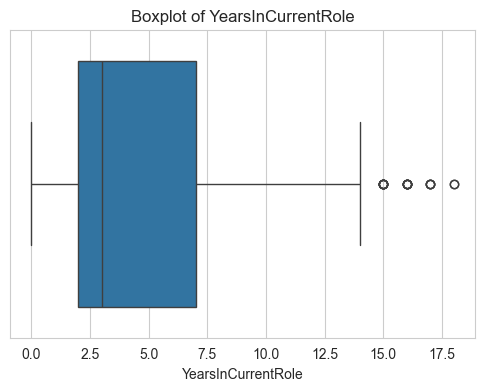

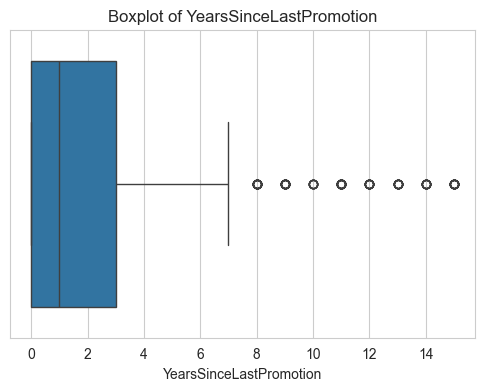

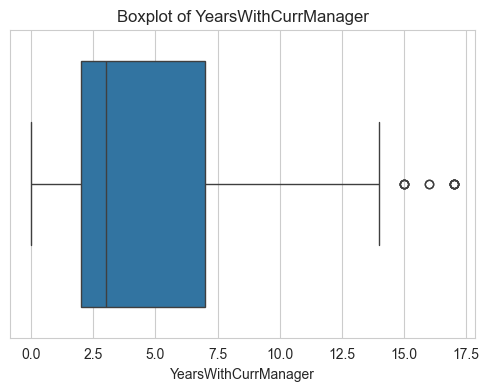

In [31]:
# Select all numerical columns automatically
numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns

# Boxplot for numerical columns
for col in numerical_columns:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x=df[col], whis=1.5)  # Match IQR outlier thresholds
    plt.title(f'Boxplot of {col}')
    plt.xlabel(col)
    plt.show()

In [32]:
#Identify outliers using IQR method
outlier_counts = {}

for col in numerical_columns:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_threshold = Q1 - 1.5 * IQR
    upper_threshold = Q3 + 1.5 * IQR

    # Count outliers
    outliers = df[(df[col] < lower_threshold) | (df[col] > upper_threshold)]
    outlier_counts[col] = len(outliers)

    # Print outlier summary
    print(f"{col}: {len(outliers)} outliers")
    print(f"Lower Threshold: {lower_threshold:.2f}, Upper Threshold: {upper_threshold:.2f}\n")

# Print total number of outliers per column
print("Summary of Outliers in Each Column:", outlier_counts)


Age: 0 outliers
Lower Threshold: 10.50, Upper Threshold: 62.50

Attrition: 237 outliers
Lower Threshold: 0.00, Upper Threshold: 0.00

DailyRate: 0 outliers
Lower Threshold: -573.00, Upper Threshold: 2195.00

DistanceFromHome: 0 outliers
Lower Threshold: -16.00, Upper Threshold: 32.00

Education: 0 outliers
Lower Threshold: -1.00, Upper Threshold: 7.00

EmployeeCount: 0 outliers
Lower Threshold: 1.00, Upper Threshold: 1.00

EmployeeNumber: 0 outliers
Lower Threshold: -1105.50, Upper Threshold: 3152.50

EnvironmentSatisfaction: 0 outliers
Lower Threshold: -1.00, Upper Threshold: 7.00

HourlyRate: 0 outliers
Lower Threshold: -5.62, Upper Threshold: 137.38

JobInvolvement: 0 outliers
Lower Threshold: 0.50, Upper Threshold: 4.50

JobLevel: 0 outliers
Lower Threshold: -2.00, Upper Threshold: 6.00

JobSatisfaction: 0 outliers
Lower Threshold: -1.00, Upper Threshold: 7.00

MonthlyIncome: 114 outliers
Lower Threshold: -5291.00, Upper Threshold: 16581.00

MonthlyRate: 0 outliers
Lower Threshold:

**Some Columns Have No Outliers**
- Age, DailyRate, DistanceFromHome, Education, EmployeeCount, EmployeeNumber, EnvironmentSatisfaction, HourlyRate, JobInvolvement, JobLevel, JobSatisfaction, MonthlyRate, PercentSalaryHike, RelationshipSatisfaction, StandardHours, WorkLifeBalance - No outliers detected. These values seem to be evenly distributed and fall within normal expected ranges.

Performance ratings of 4 were flagged as outliers, but this isn't a true outlier issue.

Tenure-related outliers suggest that employees who stay very long might be different.

Promotion timing and training frequency outliers could be linked to attrition risk.

#### Handle Outliers

In [33]:
# Cap outliers
columns_to_filter = ['Age', 'DistanceFromHome', 'MonthlyIncome', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion']

for col in columns_to_filter:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1 
    lower_threshold = Q1 - 1.5 * IQR
    upper_threshold = Q3 + 1.5 * IQR

    # Apply capping
    df[col] = np.where(df[col] < lower_threshold, lower_threshold, df[col])
    df[col] = np.where(df[col] > upper_threshold, upper_threshold, df[col])

print(f"Dataset size after capping: {df.shape[0]}")

Dataset size after capping: 1470


**Anything below Q1 - 1.5 * IQR or above Q3 + 1.5 * IQR is considered an outlier.**

**The above step caps the outliers instead of removing them.** 
- Values below the lower threshold are set to the lower threshold.
- Values above the upper threshold are set to the upper threshold.
- Prevents Extreme Outliers from Skewing Analysis:

This approach preserves the data but ensures extreme values don't overly influence the model.

#### Encoding Categorical Variables

In [34]:
# Define categorical columns to encode
categorical_columns = ['BusinessTravel', 'Department', 'EducationField', 
                       'Gender', 'JobRole', 'MaritalStatus', 'OverTime']

# Apply one-hot encoding
df_encoded = pd.get_dummies(df, columns=categorical_columns, drop_first=True)

# Ensure all numerical features are preserved
print(f"Dataset shape after encoding: {df_encoded.shape}")
print("Columns AFTER encoding:", df_encoded.columns.tolist())

Dataset shape after encoding: (1470, 48)
Columns AFTER encoding: ['Age', 'Attrition', 'DailyRate', 'DistanceFromHome', 'Education', 'EmployeeCount', 'EmployeeNumber', 'EnvironmentSatisfaction', 'HourlyRate', 'JobInvolvement', 'JobLevel', 'JobSatisfaction', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction', 'StandardHours', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager', 'BusinessTravel_Travel_frequently', 'BusinessTravel_Travel_rarely', 'Department_Research & development', 'Department_Sales', 'EducationField_Life sciences', 'EducationField_Marketing', 'EducationField_Medical', 'EducationField_Other', 'EducationField_Technical degree', 'Gender_Male', 'JobRole_Human resources', 'JobRole_Laboratory technician', 'JobRole_Manager', 'JobRole_Manufacturing director', 'JobRole_Research director',

**The above step converts categorical text features into numbers using one-hot encoding.**
- Ensures no information is lost while avoiding multicollinearity.
- Makes the dataset model-ready for machine learning algorithms.

### Save Cleaned Dataset

In [36]:
df.to_csv('../data/processed/cleaned_dataset.csv', index=False)

## Feature Engineering

#### Feature Selection - Removing Constant Features

In [37]:
# Identify Non-Informative Features
# Check for constant features
constant_features = [col for col in df.columns if df[col].nunique() == 1]
print("Constant Features:", constant_features)

# Drop constant features
df.drop(columns=constant_features, inplace=True)
print(f"Dataset shape after dropping constant features: {df.shape}")

Constant Features: ['EmployeeCount', 'StandardHours']
Dataset shape after dropping constant features: (1470, 32)


Non-Informative Features are columns that do not provide any meaningful variation in the dataset.

Features with only one unique value (constant across all rows) cannot help the model make distinctions between employees who left vs. those who stayed.

Removing them improves model efficiency by reducing dimensionality without losing useful information.

**Two Constant Features Were Found:**
- EmployeeCount: Every row had the same value (1, representing each employee).
- StandardHours: Every row had the same value (80 hours, meaning all employees have the same standard work hours).
- 
These Features Were Dropped.

#### Identifying Highly Correlated Features

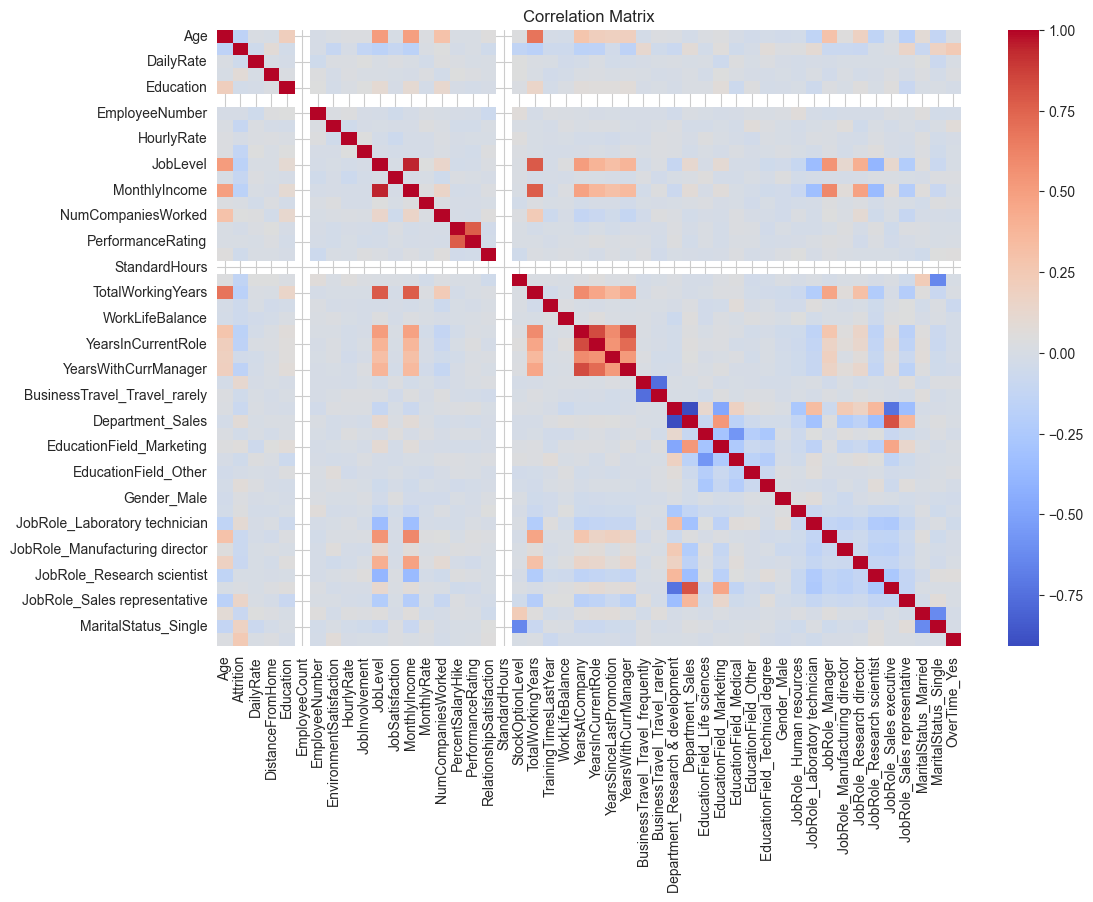

Highly Correlated Features (|corr| > 0.8):


JobLevel                           MonthlyIncome              0.945557
YearsAtCompany                     YearsWithCurrManager       0.831760
                                   YearsInCurrentRole         0.829616
Department_Sales                   JobRole_Sales executive    0.808869
Department_Research & development  Department_Sales          -0.906818
dtype: float64

In [38]:
# Compute correlation matrix after encoding
corr_matrix = df_encoded.corr()

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=False, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

# Identify and display highly correlated features (|corr| > 0.8, excluding self-correlations)
high_corr_pairs = (
    corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))  # Remove self-correlations
    .stack()
    .sort_values(ascending=False)
)
high_corr_pairs = high_corr_pairs[abs(high_corr_pairs) > 0.8]  # Apply threshold

# Display high correlations
print("Highly Correlated Features (|corr| > 0.8):")
display(high_corr_pairs)


Revisting highly correlated features after I encoded the catagorical variables.
Here are the new findings:

- Employees at higher job levels earn significantly more. This was previously observed (Job Level - Monthly Income was 0.77), but here, the correlation is even stronger (0.95).
- The longer an employee stays at a company, the longer they tend to stay under one manager. This is expected, but it suggests that managerial stability may be an attrition factor.
- Employees tend to stay in the same role for a long time. This suggests that promotions or job transitions within the company may not be frequent.
- Job Level & Total Working Years (0.78) was removed from this list, suggesting that it no longer crosses the high threshold (> 0.8).

#### Feature Selection - Dropping Highly Correlated Features

In [39]:
# Features we want to keep no matter what
protected_features = {
    'Attrition', 'Attrition_numeric', 'MonthlyIncome', 
    'JobSatisfaction', 'YearsAtCompany', 'WorkLifeBalance', 
    'EnvironmentSatisfaction', 'OverTime_Yes'
}

# Initialize feature drop list
to_drop = set()

# Drop only one feature from each highly correlated pair (while keeping protected ones)
for feature1, feature2 in high_corr_pairs.index:
    if feature1 in protected_features or feature2 in protected_features:
        continue  # Skip protected features
    if feature1 not in to_drop and feature2 not in to_drop:
        to_drop.add(feature2)  # Drop only one feature from the pair

# Print features about to be dropped
print("Features marked for dropping:", to_drop)

# Ensure we retain at least 15 features
min_features_to_keep = 15
remaining_features = set(df_encoded.columns) - to_drop

if len(remaining_features) < min_features_to_keep:
    print(f"Too many features being dropped! Adjusting threshold...")
    to_drop = set(list(to_drop)[:len(to_drop) - (min_features_to_keep - len(remaining_features))])

# Ensure protected features are NOT in the to_drop list
to_drop -= protected_features  # Explicitly remove them if they were added

# Drop the selected features
df_encoded.drop(columns=to_drop, inplace=True, errors='ignore')  
print(f"Dataset shape after dropping {len(to_drop)} highly correlated features: {df_encoded.shape}")
print("Dropped Features:", to_drop)

Features marked for dropping: {'JobRole_Sales executive', 'Department_Sales'}
Dataset shape after dropping 2 highly correlated features: (1470, 46)
Dropped Features: {'JobRole_Sales executive', 'Department_Sales'}


This step is crucial for:
- Reducing redundancy – Highly correlated features provide redundant information and don’t improve the model.
- Preventing multicollinearity – Features that are too correlated can negatively impact certain models.
- Improving model performance – Removing unnecessary features helps models generalize better, improving accuracy and reducing overfitting.
- Making the model interpretable – Keeping only the most relevant features simplifies analysis.

We made sure important variables weren’t removed, such as:
- Attrition (target variable)
- MonthlyIncome (a key factor in employee retention)
- JobSatisfaction, WorkLifeBalance, EnvironmentSatisfaction (important predictors for attrition)
- OverTime_Yes (previously shown to impact attrition rates)

**Department_Sales and JobRole_Sales executive were removed.**
- They had a high correlation (0.81), meaning they provided redundant information.
- We only need one of them to capture the same insight in the model.

Number of features reduced from 47 to 45 - fewer features means less complexity and a faster model.

#### Saving the Processed Dataset

In [40]:
df_encoded.to_csv('../data/processed/processed_dataset.csv', index=False)
print("Processed dataset saved.")

Processed dataset saved.


### Feature Scaling

#### Feature Selection Before Scaling

In [41]:
# Define features (X) and target (y)
X = df_encoded.drop(columns=['Attrition'])
y = df_encoded['Attrition']

# Drop non-informative features
features_to_drop = ['EmployeeCount', 'StandardHours']
X = X.drop(columns=[col for col in features_to_drop if col in X.columns], errors='ignore')

# Ensure no null values in target
if y.isnull().any():
    print("Removing null values from y...")
    X = X[~y.isnull()]
    y = y[~y.isnull()]

# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply StandardScaler to numerical features only
scaler = StandardScaler()

# Identify numerical columns
numerical_columns = X.select_dtypes(include=['int64', 'float64']).columns
X_train[numerical_columns] = scaler.fit_transform(X_train[numerical_columns])
X_test[numerical_columns] = scaler.transform(X_test[numerical_columns])

# Verify scaling
print("Feature scaling applied successfully!")
print(f"X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")


Feature scaling applied successfully!
X_train shape: (1176, 43), X_test shape: (294, 43)


This code is preparing data by selecting features, cleaning data, splitting it into training and testing sets, and applying feature scaling.
- 1,176 rows in X_train (80% of dataset).
- 294 rows in X_test (20% of dataset).
- 43 total features (after dropping non-informative ones).

#### Feature Scaling with StandardScaler

In [44]:
# Apply scaling to numerical features
scaler = StandardScaler()

# Identify numerical columns
numerical_columns = X.select_dtypes(include=['int64', 'float64']).columns

# Scale numerical features and store in separate variables
X_train_scaled = scaler.fit_transform(X_train[numerical_columns])
X_test_scaled = scaler.transform(X_test[numerical_columns])

# Convert back to DataFrame with correct column names
scaled_train = pd.DataFrame(X_train_scaled, columns=numerical_columns)
scaled_test = pd.DataFrame(X_test_scaled, columns=numerical_columns)

# Save the scaled datasets
scaled_train.to_csv('../data/processed/scaled_train.csv', index=False)
scaled_test.to_csv('../data/processed/scaled_test.csv', index=False)

print("Scaled data saved.")

Scaled data saved.


## Random Forest Model

### Data Preparation

In [45]:
# Ensure 'Attrition' is in df_encoded
if 'Attrition' not in df_encoded.columns:
    raise KeyError("Critical Error: 'Attrition' column is missing from df_encoded!")

# Separate features (X) and target (y)
X = df_encoded.drop(columns=['Attrition'])  # Use 'Attrition' instead of 'Attrition_numeric'
y = df_encoded['Attrition']

# Drop non-informative features if they exist
features_to_drop = ['EmployeeCount', 'StandardHours']
X = X.drop(columns=[col for col in features_to_drop if col in X.columns], errors='ignore')

# Check for null values before splitting
if X.isnull().sum().any():
    print("Warning: Null values detected in features! Consider handling missing values before model training.")
    print(X.isnull().sum()[X.isnull().sum() > 0])  # Print columns with missing values

if y.isnull().sum() > 0:
    raise ValueError("Critical Error: Target variable 'y' contains missing values!")

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# Print dataset shapes
print(f"Training Set Shape: {X_train.shape}")
print(f"Testing Set Shape: {X_test.shape}")

# Print class distribution
print("\nTarget Distribution in Training Set:")
print(y_train.value_counts(normalize=True) * 100)

print("\nTarget Distribution in Testing Set:")
print(y_test.value_counts(normalize=True) * 100)

Training Set Shape: (1029, 43)
Testing Set Shape: (441, 43)

Target Distribution in Training Set:
Attrition
0    83.867833
1    16.132167
Name: proportion, dtype: float64

Target Distribution in Testing Set:
Attrition
0    83.900227
1    16.099773
Name: proportion, dtype: float64


Dataset is properly split into training and testing sets with 43 features each.

Attrition cases are stratified, maintaining the original class distribution (16% attrition, 84% retention).

Missing values are checked, ensuring I don’t have null values that could disrupt model training.

Non-informative features (EmployeeCount, StandardHours) are removed, cleaning up the dataset.

### Apply SMOTE to Balance the Training Dataset

In [46]:
# Apply SMOTE to balance the training dataset
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Print class distribution
print("Class distribution after balancing:")
print(y_train_balanced.value_counts())

Class distribution after balancing:
Attrition
0    863
1    863
Name: count, dtype: int64


Before SMOTE: There were 863 employees who stayed (Attrition = 0) and 166 employees who left (Attrition = 1) (based on the previous dataset split).

After SMOTE: Both classes now contain 863 employees each, ensuring that the dataset is balanced.

### Feature Scaling

In [47]:
# Initialize StandardScaler
scaler = StandardScaler()

# Fit the scaler on the training set and transform both training and testing sets
X_train_scaled = scaler.fit_transform(X_train_balanced)
X_test_scaled = scaler.transform(X_test)

# Print updated shapes
print(f"Scaled Training Data Shape: {X_train_scaled.shape}")
print(f"Scaled Testing Data Shape: {X_test_scaled.shape}")

Scaled Training Data Shape: (1726, 43)
Scaled Testing Data Shape: (441, 43)


SMOTE Successfully Balanced the Training Data
- Before SMOTE: X_train had 1029 samples.
- After SMOTE: X_train_balanced has 1726 samples (863 for each class).
- This confirms that SMOTE correctly oversampled the minority class (Attrition = 1) to match the majority class (Attrition = 0).

Feature Scaling Applied Correctly
- X_train_scaled.shape - (1726, 43)
- X_test_scaled.shape - (441, 43)
- Both datasets have 43 features, meaning that no columns were dropped during preprocessing.

### Model Training and Evaluation

#### Train the Random Forest Model

In [48]:
# Initialize the Random Forest model
rf_model = RandomForestClassifier(
    random_state=42, 
    n_estimators=100,  # Number of trees in the forest
    max_depth=None,  # grows trees until all leaves are pure
    min_samples_split=2,  # Minimum samples required to split a node
    min_samples_leaf=1  # Minimum samples per leaf
)
# Train the model on the balanced dataset
rf_model.fit(X_train_scaled, y_train_balanced)

RandomForestClassifier(random_state=42)

Created a Random Forest model with the following parameters:
- random_state=42: Ensures reproducibility.
- n_estimators=100: Uses 100 decision trees in the forest.
- max_depth=None: Trees grow until all leaves are pure (no depth limit).
- min_samples_split=2: A node will split if at least 2 samples are there
- min_samples_leaf=1: A leaf node can have as few as 1 sample

#### Feature Importance

In [49]:
# Extract and display feature importance
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Option to display all features or just the top N
top_n = 10  # Change this to None if you want all features
if top_n:
    print(f"Top {top_n} Features:")
    print(feature_importances.head(top_n))
else:
    print("Feature Importances:")
    print(feature_importances)

Top 10 Features:
                 Feature  Importance
42          OverTime_Yes    0.092197
41  MaritalStatus_Single    0.077483
16      StockOptionLevel    0.055331
10         MonthlyIncome    0.052489
23  YearsWithCurrManager    0.038346
21    YearsInCurrentRole    0.037932
20        YearsAtCompany    0.035641
0                    Age    0.035292
2       DistanceFromHome    0.031355
11           MonthlyRate    0.029940


As the model sits now, it is telling us the top 10 Most Important Features for predicting employee attrition are:
- OverTime_Yes – Most influential in attrition. Employees working overtime are more likely to leave.
- MaritalStatus_Single – Single employees may be more likely to leave.
- StockOptionLevel – Employees with stock options may be more likely to stay.
- MonthlyIncome – Salary impacts attrition decisions.
- YearsWithCurrManager – Stronger relationships with managers may lead to lower attrition.
- YearsInCurrentRole – Employees in the same role for too long may be more likely to leave.
- YearsAtCompany – Longer tenure may correlate with stability or burnout.
- Age – Younger employees may leave more often for better opportunities.
- DistanceFromHome – Longer commutes may contribute to attrition.
- MonthlyRate – Monthly salary variations could have some impact.

In [50]:
# Convert scaled arrays back to DataFrames before dropping features
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train_balanced.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns)

# Set the importance threshold
low_importance_threshold = 0.02  

# Identify low-importance features
low_importance_features = feature_importances[feature_importances["Importance"] < low_importance_threshold]["Feature"].tolist()
print("Low-importance features to drop:", low_importance_features)

# Drop low-importance features
X_train_selected = X_train_scaled_df.drop(columns=low_importance_features, errors='ignore')
X_test_selected = X_test_scaled_df.drop(columns=low_importance_features, errors='ignore')

# Print new shape after feature selection
print(f"Shape after feature selection - Training: {X_train_selected.shape}, Testing: {X_test_selected.shape}")

Low-importance features to drop: ['TrainingTimesLastYear', 'Education', 'PercentSalaryHike', 'JobRole_Laboratory technician', 'MaritalStatus_Married', 'Gender_Male', 'JobRole_Sales representative', 'BusinessTravel_Travel_rarely', 'EducationField_Marketing', 'EducationField_Medical', 'EducationField_Life sciences', 'Department_Research & development', 'EducationField_Technical degree', 'JobRole_Human resources', 'JobRole_Research scientist', 'PerformanceRating', 'JobRole_Manufacturing director', 'JobRole_Research director', 'EducationField_Other', 'JobRole_Manager']
Shape after feature selection - Training: (1726, 23), Testing: (441, 23)


Low-importance features successfully identified and dropped
- Dropped 20 low-importance features that had minimal impact on predicting attrition.
- The remaining dataset now contains 23 features, half of the original 43 features.

### Retrain the model 

In [51]:
# Initialize the Random Forest model
rf_model_selected = RandomForestClassifier(
    random_state=42,
    n_estimators=100,  # Keeping the same hyperparameters for comparison
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1
)

# Train the model on the selected features
rf_model_selected.fit(X_train_selected, y_train_balanced)

# Make predictions on the test set
y_pred = rf_model_selected.predict(X_test_selected)

# Print completion message
print("Model retraining with selected features is complete!")

Model retraining with selected features is complete!


#### Model Evaluation

In [52]:
# Predict on the test set using the retrained model
y_pred_selected = rf_model_selected.predict(X_test_selected)

# Display Confusion Matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_selected))

# Display Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_selected))

# Calculate Accuracy
accuracy_selected = accuracy_score(y_test, y_pred_selected)
print(f"\nModel Accuracy After Feature Selection: {accuracy_selected:.4f}")


Confusion Matrix:
[[345  25]
 [ 44  27]]

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.93      0.91       370
           1       0.52      0.38      0.44        71

    accuracy                           0.84       441
   macro avg       0.70      0.66      0.67       441
weighted avg       0.83      0.84      0.83       441


Model Accuracy After Feature Selection: 0.8435


This code is evaluating the performance of a machine learning model. 

The **Confusion Matrix** shows the number of correct and incorrect predictions for each class.
- 345 True Negatives: Correctly predicted employees who stayed.
- 27 True Positives: Correctly predicted employees who left.
- 25 False Positives: Wrongly predicted employees would leave, but they stayed.
- 44 False Negatives: Employees who left but were predicted to stay

The model struggles to identify employees who actually leave - 44 out of 71 attrition cases were missed.

The **Classification Report** provides precision, recall, and F1-score for each class.
- High Precision for "Stayed" (0.89) - When the model predicts an employee will stay, it is usually correct.
- Low Recall for "Left" (0.38) - The model fails to identify many attrition cases (only 38% detected).
- Low Precision for "Left" (0.52) - Many employees predicted to leave actually stayed, causing false positives.

Model Accuracy After Feature Selection: 84.35%

Macro Average F1-score: 0.67 (meaning performance is better for "Stayed" than "Left").

The model is very accurate at predicting employees who stay but not great at predicting who will leave.

#### Addressing Class Imbalance

In [53]:
rf_model_weighted = RandomForestClassifier(
    random_state=42, 
    n_estimators=100,
    class_weight='balanced'  # Adjusts for the imbalance
)
rf_model_weighted.fit(X_train_selected, y_train_balanced)


RandomForestClassifier(class_weight='balanced', random_state=42)

#### Evaluate Update Model 

In [54]:
# Predict on the test set using the balanced model
y_pred_weighted = rf_model_weighted.predict(X_test_selected)

# Display Confusion Matrix
print("\nConfusion Matrix (Balanced Random Forest):")
print(confusion_matrix(y_test, y_pred_weighted))

# Display Classification Report
print("\nClassification Report (Balanced Random Forest):")
print(classification_report(y_test, y_pred_weighted))

# Calculate Accuracy
accuracy_weighted = accuracy_score(y_test, y_pred_weighted)
print(f"\nModel Accuracy After Addressing Class Imbalance: {accuracy_weighted:.4f}")



Confusion Matrix (Balanced Random Forest):
[[345  25]
 [ 44  27]]

Classification Report (Balanced Random Forest):
              precision    recall  f1-score   support

           0       0.89      0.93      0.91       370
           1       0.52      0.38      0.44        71

    accuracy                           0.84       441
   macro avg       0.70      0.66      0.67       441
weighted avg       0.83      0.84      0.83       441


Model Accuracy After Addressing Class Imbalance: 0.8435


**There was no change in the Accuracy, Recall, or Precision**

### Hyperparameter Tuning

#### Grid Search for Hyperparameter Optimization

In [55]:
# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='accuracy')

# Fit the model
grid_search.fit(X_train_scaled, y_train_balanced)

# Best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Best Parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Best Score: 0.9381084024461759


#### Updated model with best parameters 

In [56]:
# Train the best Random Forest model using Grid Search results
rf_optimized = RandomForestClassifier(
    max_depth=None,           
    min_samples_split=2,      
    n_estimators=200,         
    random_state=42,          
    class_weight='balanced'
)

# Fit the model on the training data
rf_optimized.fit(X_train_selected, y_train_balanced)

# Make predictions on the test set
y_pred_optimized = rf_optimized.predict(X_test_selected)

#### Evaluate the Optimized Model

In [57]:
# Confusion Matrix
print("\nConfusion Matrix (Optimized Random Forest):")
print(confusion_matrix(y_test, y_pred_optimized))

# Classification Report
print("\nClassification Report (Optimized Random Forest):")
print(classification_report(y_test, y_pred_optimized))

# Calculate Accuracy
accuracy_optimized = accuracy_score(y_test, y_pred_optimized)
print(f"\nOptimized Model Accuracy: {accuracy_optimized:.4f}")

# Calculate AUC-ROC Score
y_prob_optimized = rf_optimized.predict_proba(X_test_selected)[:,1]  # Get probability scores for attrition class
auc_score_optimized = roc_auc_score(y_test, y_prob_optimized)
print(f"\nAUC-ROC Score (Optimized Random Forest): {auc_score_optimized:.4f}")


Confusion Matrix (Optimized Random Forest):
[[342  28]
 [ 42  29]]

Classification Report (Optimized Random Forest):
              precision    recall  f1-score   support

           0       0.89      0.92      0.91       370
           1       0.51      0.41      0.45        71

    accuracy                           0.84       441
   macro avg       0.70      0.67      0.68       441
weighted avg       0.83      0.84      0.83       441


Optimized Model Accuracy: 0.8413

AUC-ROC Score (Optimized Random Forest): 0.8011


The Grid Search-tuned Random Forest model shows slight improvements but still struggles with attrition recall.
- Now correctly identifying 41% of attrition cases instead of 38%.
- Accuracy remains stable (~84%), meaning no major performance degradation.
- AUC-ROC = 0.8011: Indicates that the model has a good ability to distinguish between employees who stay vs. leave.

The model still  fails to capture 59% of employees who actually left (False Negatives = 42).
- Even though the AUC-ROC score is good, recall for Class 1 is still too low.

## Logistic Regression Model

In [58]:
# Initialize Logistic Regression with class balancing
log_model = LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000)

# Train the model
log_model.fit(X_train_selected, y_train_balanced)

# Predict on the test set
y_pred_log = log_model.predict(X_test_selected)

# Evaluate model performance
print("\nConfusion Matrix (Logistic Regression):")
print(confusion_matrix(y_test, y_pred_log))

print("\nClassification Report (Logistic Regression):")
print(classification_report(y_test, y_pred_log))

# Calculate Accuracy
accuracy_log = accuracy_score(y_test, y_pred_log)
print(f"\nModel Accuracy (Logistic Regression): {accuracy_log:.4f}")



Confusion Matrix (Logistic Regression):
[[320  50]
 [ 27  44]]

Classification Report (Logistic Regression):
              precision    recall  f1-score   support

           0       0.92      0.86      0.89       370
           1       0.47      0.62      0.53        71

    accuracy                           0.83       441
   macro avg       0.70      0.74      0.71       441
weighted avg       0.85      0.83      0.83       441


Model Accuracy (Logistic Regression): 0.8254


Logistic Regression vs. Optimized Random Forest
- Accuracy decreased by 1.6%
- Recall increased by 21%
- Slight decrease in Precision (.51 vs .47)
- An improvement in the balance (F1-Score)
- False Negatives (Attrition cases missed) dropped from 42 to 27.
- True Positives (Attrition cases correctly identified) increased from 29 to 44.
- False Positives increased from 28 to 50, meaning more employees were incorrectly predicted to leave

#### Tune Decision Threshold

In [59]:
# Get predicted probabilities instead of hard predictions
y_prob_log = log_model.predict_proba(X_test_selected)[:, 1]

# Adjust threshold to 0.4 (instead of default 0.5)
threshold = 0.4
y_pred_adjusted = np.where(y_prob_log >= threshold, 1, 0)

# Evaluate with new threshold
print("\nConfusion Matrix (Logistic Regression with Threshold 0.4):")
print(confusion_matrix(y_test, y_pred_adjusted))

print("\nClassification Report (Logistic Regression with Threshold 0.4):")
print(classification_report(y_test, y_pred_adjusted))



Confusion Matrix (Logistic Regression with Threshold 0.4):
[[306  64]
 [ 20  51]]

Classification Report (Logistic Regression with Threshold 0.4):
              precision    recall  f1-score   support

           0       0.94      0.83      0.88       370
           1       0.44      0.72      0.55        71

    accuracy                           0.81       441
   macro avg       0.69      0.77      0.71       441
weighted avg       0.86      0.81      0.83       441



The Logistic Regression model with a lower threshold (0.4) has significantly improved recall while maintaining a reasonable level of accuracy.

- True Positives (Attrition cases correctly predicted) increased from 44 to 51.
- False Negatives (missed attrition cases) dropped from 27 to 20.
- Recall for attrition cases improved from 62% to 72% (model is much better at identifying employees likely to leave).
- False Positives increased (from 50 to 64), meaning more employees were incorrectly classified as leaving.
- Precision for attrition cases dropped slightly (from 47% to 44%), which means that of the employees predicted to leave, 56% actually stayed.

### Train & Evaluate XGBoost

In [60]:
#Train XGBoost with class imbalance handling
xgb_model = XGBClassifier(scale_pos_weight=len(y_train_balanced)/sum(y_train_balanced), random_state=42)
xgb_model.fit(X_train_selected, y_train_balanced)

# Predict on the test set
y_pred_xgb = xgb_model.predict(X_test_selected)

# Evaluate XGBoost model
print("\nConfusion Matrix (XGBoost):")
print(confusion_matrix(y_test, y_pred_xgb))

print("\nClassification Report (XGBoost):")
print(classification_report(y_test, y_pred_xgb))

# Calculate Accuracy
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print(f"\nModel Accuracy (XGBoost): {accuracy_xgb:.4f}")

# Calculate AUC-ROC Score
y_prob_xgb = xgb_model.predict_proba(X_test_selected)[:,1]
auc_score_xgb = roc_auc_score(y_test, y_prob_xgb)
print(f"\nAUC-ROC Score (XGBoost): {auc_score_xgb:.4f}")



Confusion Matrix (XGBoost):
[[342  28]
 [ 42  29]]

Classification Report (XGBoost):
              precision    recall  f1-score   support

           0       0.89      0.92      0.91       370
           1       0.51      0.41      0.45        71

    accuracy                           0.84       441
   macro avg       0.70      0.67      0.68       441
weighted avg       0.83      0.84      0.83       441


Model Accuracy (XGBoost): 0.8413

AUC-ROC Score (XGBoost): 0.7870


The XGBoost model performs very similarly to the optimized Random Forest model, with no significant improvements in recall for attrition cases.

**Since Logistic Regression with a threshold of 0.4 had the best recall (72%) for predicting attrition cases, I will finalize this model.**

### Save the model

In [61]:
models_dir = "../models"

# Create the directory if it doesn't exist
if not os.path.exists(models_dir):
    os.makedirs(models_dir)
    print(f"Created directory: {models_dir}")

# Save the trained model
joblib.dump(log_model, os.path.join(models_dir, "logistic_regression_model.pkl"))

# Save the StandardScaler for consistent data transformation
joblib.dump(scaler, os.path.join(models_dir, "scaler.pkl"))

print("Final model and scaler saved successfully!")

Final model and scaler saved successfully!


### Test the model

In [62]:
# Load the saved model and scaler
log_model = joblib.load("../models/logistic_regression_model.pkl")
scaler = joblib.load("../models/scaler.pkl")

print("Model and scaler loaded successfully!")

Model and scaler loaded successfully!


In [64]:
# Get the exact features used in training
model_features = list(log_model.feature_names_in_)
scaler_features = list(scaler.feature_names_in_)

# Ensure model and scaler use the same features
if set(model_features) != set(scaler_features):
    print("Model and Scaler have mismatched features! Retraining scaler...")
    
    # Retrain scaler on model features
    df_selected = pd.read_csv("../data/processed/processed_dataset.csv")[model_features]
    new_scaler = StandardScaler().fit(df_selected)

    # Save the updated scaler
    joblib.dump(new_scaler, "../models/scaler.pkl")
    scaler = new_scaler  # Update scaler in session
    print("Scaler retrained successfully.")

# Create a new employee's data (Ensure only model features are used)
new_employee_data = {
    'Age': 18, 'DailyRate': 500, 'DistanceFromHome': 10, 'EmployeeNumber': 1234,
    'EnvironmentSatisfaction': 2, 'HourlyRate': 20, 'JobInvolvement': 3,
    'JobLevel': 2, 'JobSatisfaction': 4, 'MonthlyIncome': 6000, 'MonthlyRate': 12000,
    'NumCompaniesWorked': 2, 'RelationshipSatisfaction': 2, 'StockOptionLevel': 1,
    'TotalWorkingYears': 10, 'WorkLifeBalance': 3, 'YearsAtCompany': 7,
    'YearsInCurrentRole': 5, 'YearsSinceLastPromotion': 1, 'YearsWithCurrManager': 6,
    'BusinessTravel_Travel_frequently': 0, 'MaritalStatus_Single': 0, 'OverTime_Yes': 1
}

# Convert to DataFrame
new_employee_df = pd.DataFrame([new_employee_data])

# Drop unexpected features before adding missing ones
unexpected_features = set(new_employee_df.columns) - set(model_features)
if unexpected_features:
    print(f"Dropping unexpected features: {unexpected_features}")
    new_employee_df = new_employee_df.drop(columns=unexpected_features, errors='ignore')

# Add missing features with defaults
missing_features = set(model_features) - set(new_employee_df.columns)
if missing_features:
    print(f"Adding missing features: {missing_features}")
    for feature in missing_features:
        if feature in ['BusinessTravel_Travel_frequently', 'MaritalStatus_Single', 'OverTime_Yes']:
            new_employee_df[feature] = 0  # Default categorical
        else:
            new_employee_df[feature] = new_employee_df.median(numeric_only=True)[feature]  # Default numerical

### Ensure feature order matches model
new_employee_df = new_employee_df[model_features]

### Scale input and predict
# Convert the scaled result back into a DataFrame with the same feature names
new_employee_scaled = pd.DataFrame(scaler.transform(new_employee_df), columns=new_employee_df.columns)
probability = log_model.predict_proba(new_employee_scaled)[:, 1]

### Output Prediction
prediction = (probability >= 0.4).astype(int)
print(f"Probability of Attrition: {probability[0]:.2f}")
print(f"Predicted Attrition: {'Yes' if prediction[0] == 1 else 'No'}")


Model and Scaler have mismatched features! Retraining scaler...
Scaler retrained successfully.
Probability of Attrition: 0.72
Predicted Attrition: Yes


### Prepare for visualization in Power BI 

In [67]:
# Load the processed dataset
file_path = "../data/processed/processed_dataset.csv"
df = pd.read_csv(file_path)

# Drop the target variable (we want to predict this)
df = df.drop(columns=["Attrition"], errors="ignore")

# Features expected by the trained model
selected_features = [
    'Age', 'DailyRate', 'DistanceFromHome', 'EmployeeNumber', 'EnvironmentSatisfaction',
    'HourlyRate', 'JobInvolvement', 'JobLevel', 'JobSatisfaction', 'MonthlyIncome',
    'MonthlyRate', 'NumCompaniesWorked', 'RelationshipSatisfaction', 'StockOptionLevel',
    'TotalWorkingYears', 'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole',
    'YearsSinceLastPromotion', 'YearsWithCurrManager', 'BusinessTravel_Travel_frequently',
    'MaritalStatus_Single', 'OverTime_Yes',
    # JobRole one-hot encoded columns
    'JobRole_Human resources', 'JobRole_Laboratory technician', 'JobRole_Manager', 
    'JobRole_Manufacturing director', 'JobRole_Research director', 'JobRole_Research scientist', 
    'JobRole_Sales representative',
    # Gender one-hot encoded columns
    'Gender_Male'
]

# Ensure all required columns exist in df (fill missing with 0)
for col in selected_features:
    if col not in df.columns:
        df[col] = 0  # Ensuring all expected features exist

# Save the updated dataset for Power BI
output_path = r"C:\Users\efran\capstone-employee-attrition\data\input_data.csv"
df.to_csv(output_path, index=False)

print(f"Updated input_data.csv saved at {output_path} with missing columns fixed.")


Updated input_data.csv saved at C:\Users\efran\capstone-employee-attrition\data\input_data.csv with missing columns fixed.


In [68]:
# Load Data
file_path = "../data/processed/processed_dataset.csv"
df = pd.read_csv(file_path)

# Define target variable
target = "Attrition"

# Define features
features = [
    "Age", "DailyRate", "DistanceFromHome", "EnvironmentSatisfaction",
    "HourlyRate", "JobInvolvement", "JobLevel", "JobSatisfaction", "MonthlyIncome",
    "MonthlyRate", "NumCompaniesWorked", "RelationshipSatisfaction", "StockOptionLevel",
    "TotalWorkingYears", "WorkLifeBalance", "YearsAtCompany", "YearsInCurrentRole",
    "YearsSinceLastPromotion", "YearsWithCurrManager", "BusinessTravel_Travel_frequently",
    "MaritalStatus_Single", "OverTime_Yes",
    "JobRole_Human resources", "JobRole_Laboratory technician", "JobRole_Manager",
    "JobRole_Manufacturing director", "JobRole_Research director", "JobRole_Research scientist",
    "JobRole_Sales representative", "Gender_Male"
]

# Data Preprocessing
X = df[features]
y = df[target]

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale numeric features
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)


# Train Model
model = LogisticRegression(random_state=42, max_iter=500)
model.fit(X_train_scaled, y_train)

# Evaluate Model
y_pred = model.predict(X_test_scaled)
print("Model Accuracy:", model.score(X_test_scaled, y_test))
print(classification_report(y_test, y_pred))

# Save Model and Scaler
joblib.dump(model, r"C:\Users\efran\capstone-employee-attrition\models\logistic_regression_model.pkl")
joblib.dump(scaler, r"C:\Users\efran\capstone-employee-attrition\models\scaler.pkl")

print("Model and Scaler Saved Successfully!")

Model Accuracy: 0.8639455782312925
              precision    recall  f1-score   support

           0       0.90      0.95      0.92       255
           1       0.48      0.31      0.38        39

    accuracy                           0.86       294
   macro avg       0.69      0.63      0.65       294
weighted avg       0.84      0.86      0.85       294

Model and Scaler Saved Successfully!


In [69]:
# Load the processed dataset
file_path = "../data/processed/processed_dataset.csv"
df = pd.read_csv(file_path)

# Drop the target variable (we want to predict this)
df = df.drop(columns=["Attrition"], errors="ignore")

# Features expected by the trained model
selected_features = [
    'Age', 'DailyRate', 'DistanceFromHome', 'EmployeeNumber', 'EnvironmentSatisfaction',
    'HourlyRate', 'JobInvolvement', 'JobLevel', 'JobSatisfaction', 'MonthlyIncome',
    'MonthlyRate', 'NumCompaniesWorked', 'RelationshipSatisfaction', 'StockOptionLevel',
    'TotalWorkingYears', 'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole',
    'YearsSinceLastPromotion', 'YearsWithCurrManager', 'BusinessTravel_Travel_frequently',
    'MaritalStatus_Single', 'OverTime_Yes',
    # JobRole one-hot encoded columns
    'JobRole_Human resources', 'JobRole_Laboratory technician', 'JobRole_Manager', 
    'JobRole_Manufacturing director', 'JobRole_Research director', 'JobRole_Research scientist', 
    'JobRole_Sales representative',
    # Gender one-hot encoded columns
    'Gender_Male'
]

# Ensure all required columns exist in df (fill missing ones with 0)
for col in selected_features:
    if col not in df.columns:
        df[col] = 0  # This ensures Power BI does not throw errors for missing columns

# Save the updated dataset for Power BI
output_path = r"C:\Users\efran\capstone-employee-attrition\data\input_data.csv"
df.to_csv(output_path, index=False)

print(f"Updated input_data.csv saved at {output_path} with new features included.")


Updated input_data.csv saved at C:\Users\efran\capstone-employee-attrition\data\input_data.csv with new features included.
